In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = np.stack(ts, axis=1)
ts = ts/np.linalg.norm(ts, axis=-1, keepdims=True)
print(ts.shape)

(847, 1, 264, 124)


In [17]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

mask = (torch.ones(264,264)-torch.eye(264)).float().cuda()

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-1*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            AA = mask*AA
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    nsubs: number of subjects
    nmods: number of modalities
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, nmods, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(torch.rand(nsubs, nmods, ncodes, nt).float().cuda())
        
#     def features(self, vecbook):
#         w = F.relu(self.w)
#         return torch.einsum('nr,ra->nra',w,vecbook).reshape(w.shape[0],-1)

    def forward(self, sub, book, mod):
        w = self.w[sub,mod]
        return torch.einsum('pt,pab->abt', w, book)
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_smooth_loss_w(w, mod):
    before = w[:,mod,:,:-1]
    after = w[:,mod,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
#     subts = subts/torch.linalg.norm(subts, dim=0, keepdims=True)
    return torch.einsum('at,bt->abt',subts,subts)*mask.unsqueeze(2)
    
x = torch.from_numpy(ts).float().cuda()
    
ntrain = 600
smooth_mult = 1
nEpochs = 5000
pPeriod = 200
nCodes = 300
suborder = np.arange(ntrain)
np.random.shuffle(suborder)

mseLoss = nn.MSELoss()
    
lrc = LowRankCodes(300*[10])
lrw = LowRankWeights(ntrain, 1, nCodes, x.shape[-1])

optim = torch.optim.Adam(
    [
        {'params': lrc.parameters(), 'lr': 1e-1, 'weight_decay': 0},
        {'params': lrw.parameters(), 'lr': 1e-1, 'weight_decay': 0},
    ]
)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)
    
for epoch in range(nEpochs):
    for i in range(1):
        sub = suborder[epoch % ntrain]
        optim.zero_grad()
        book = lrc()
        xsub = get_sub_fc(x[sub, 0])
        xhat = lrw(sub, book, 0)
        recon_loss = get_recon_loss(xsub, xhat)
        smooth_loss_fc = get_smooth_loss_fc(xhat)
        totloss = recon_loss+smooth_loss_fc
        totloss.backward()
        optim.step()
        sched.step(totloss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc]]} '
                  f'lr: {sched._last_lr}')

print('Complete')

0 recon: [0.31557388080542614, 0.2215184957470686] lr: [0.1, 0.1]
200 recon: [0.019719571200157236, 0.0011986727323401248] lr: [0.04782969000000002, 0.04782969000000002]
400 recon: [0.009879642462769154, 0.0008622513969762758] lr: [0.007976644307687259, 0.007976644307687259]
600 recon: [0.009535816529078565, 0.0012226176336081773] lr: [0.0011972515182562037, 0.0011972515182562037]
800 recon: [0.01960735617818617, 0.0008193999126473044] lr: [0.00017970102999144343, 0.00017970102999144343]
1000 recon: [0.00991437177372018, 0.0008244879186670025] lr: [2.697216055906082e-05, 2.697216055906082e-05]
1200 recon: [0.009529036268861316, 0.0012177088361368534] lr: [4.048376602284339e-06, 4.048376602284339e-06]
1400 recon: [0.019617486355175098, 0.0008153615982291252] lr: [9.261387130997902e-07, 9.261387130997902e-07]
1600 recon: [0.009912796375468515, 0.0008237860467179513] lr: [9.261387130997902e-07, 9.261387130997902e-07]
1800 recon: [0.009529045813312828, 0.0012175613630882871] lr: [9.2613871

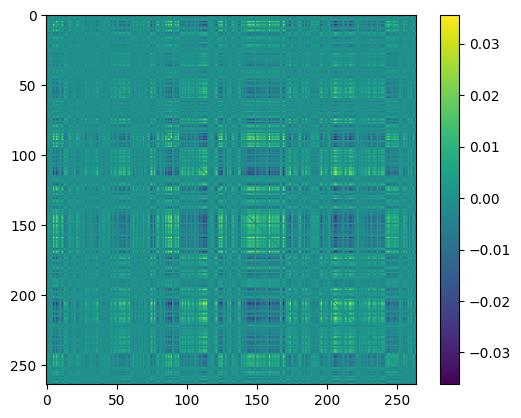

In [103]:
import matplotlib.pyplot as plt

plt.imshow(xsub[:,:,39].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [12]:
torch.linalg.norm(torch.Tensor([[1,2,3],[3,4,5]]), dim=0, keepdims=True)

tensor([[3.1623, 4.4721, 5.8310]])

In [84]:
torch.where(torch.max(tstr_out[:,0,30], dim=1).values > 50)

(tensor([ 17,  83,  97, 122, 132, 162, 169, 195, 198, 200, 208, 223, 238, 248,
         286, 289, 290, 333, 350, 434, 453, 489, 546, 614, 616, 631, 641, 705,
         716, 725, 777, 810], device='cuda:0'),)

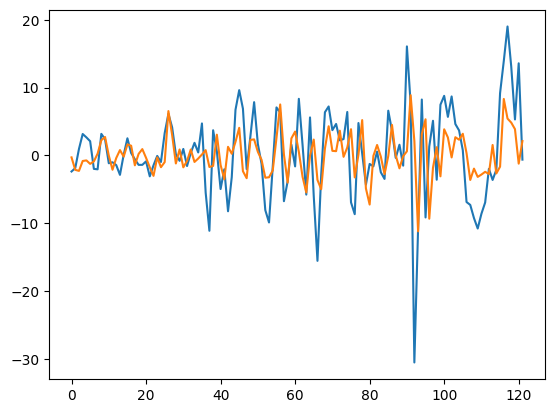

In [236]:
import matplotlib.pyplot as plt

plt.plot(tstr_out[10,0,30].detach().cpu().numpy())
plt.plot(xhat[10,30].detach().cpu().numpy())
plt.show()

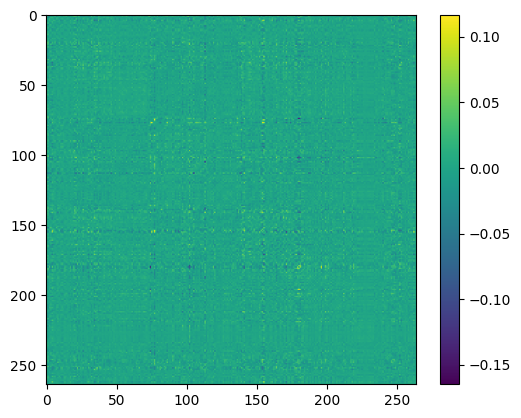

In [237]:
# Examine codebook

plt.imshow(book[10].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [238]:
# Estimate weights

nEpochs = 500
pPeriod = 100

book = lrc().detach().clone()
book.grad = None

lrw2 = LowRankWeights(tstr_in.shape[0], tstr_out.shape[1], nCodes, nw)
optim = torch.optim.Adam(lrw2.parameters(), lr=1e-1, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    for i in range(1):
        optim.zero_grad()
        xhat = lrw2(tstr_in[:,i], book, i)
        xloss = mseLoss(xhat, tstr_out[:,i])
        xloss.backward()
        optim.step()
        sched.step(xloss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {float(xloss**0.5)} lr: {float(sched._last_lr[0])}')

print('Complete')

0 recon: 97.65791320800781 lr: 0.1
100 recon: 6.755094051361084 lr: 0.08145062499999998
200 recon: 6.443493843078613 lr: 0.08145062499999998
300 recon: 6.369539737701416 lr: 0.08145062499999998
400 recon: 6.343796253204346 lr: 0.08145062499999998
499 recon: 6.331742286682129 lr: 0.08145062499999998
Complete


In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F

xec = lrw2.w[:,0].reshape(lrw2.w.shape[0],-1)
xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 200])
torch.Size([600, 200])
torch.Size([247, 200])
(847,)


In [240]:
mseLoss = nn.MSELoss()

w, _, _, _ = torch.linalg.lstsq(xectr, ytr)
yhattr = xectr@w
yhatt = xect@w
print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhatt, yt)**0.5)

tensor(29.0802, device='cuda:0', grad_fn=<PowBackward0>)
tensor(45.0205, device='cuda:0', grad_fn=<PowBackward0>)


In [241]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,30).float().cuda()
        self.l1 = nn.Linear(30,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y).squeeze()
        return y

mseLoss = nn.MSELoss()
    
mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e0)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
#     l1loss = 1e0*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.54291082970377 lr: [0.001]
1000 75.82232778426814 lr: [0.001]
2000 37.87341909602878 lr: [0.001]
3000 31.338012778762394 lr: [0.001]
4000 28.669798332492352 lr: [0.001]
5000 27.28739617013858 lr: [0.001]
6000 26.43929492096884 lr: [0.001]
7000 25.86838140932442 lr: [0.001]
8000 25.41327955679926 lr: [0.001]
9000 25.118618738382466 lr: [0.001]
9999 24.979149019576056 lr: [0.0003584859224085418]
Complete
tensor(36.4105, device='cuda:0', grad_fn=<PowBackward0>)


In [242]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [244]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.5, edp=0, wInit=1e-4, dim=10, temp=10)
optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.081035164810956 lr: [0.001]
100 39.012242669769705 lr: [0.001]
200 36.265906060414544 lr: [0.00095]
300 35.12271664620172 lr: [0.0006983372960937497]
400 34.958090840810726 lr: [0.00046329123015975297]
500 34.14083595472583 lr: [0.00030735686772502346]
600 33.62322471498495 lr: [0.00021463876394293716]
700 33.7593809300652 lr: [0.00014239574134637458]
800 34.44626667849417 lr: [8.974483193085068e-05]
900 34.228330565209426 lr: [5.373354598274025e-05]
999 34.26560540640115 lr: [3.3865535638032174e-05]
Complete
tensor(37.0512, device='cuda:0', grad_fn=<PowBackward0>)
